Time steps: 100%|██████████| 36000/36000 [2:34:45<00:00,  3.88it/s]     


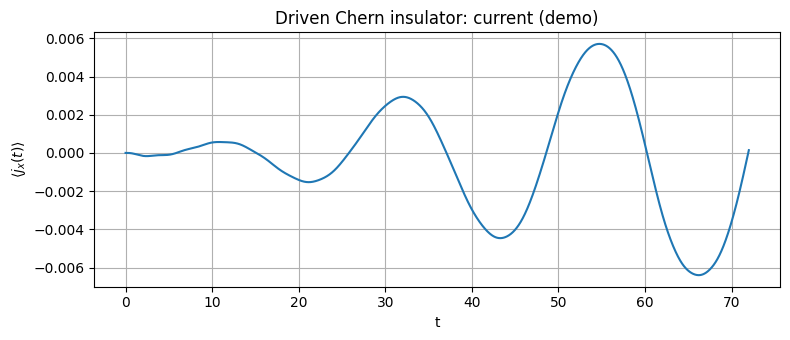

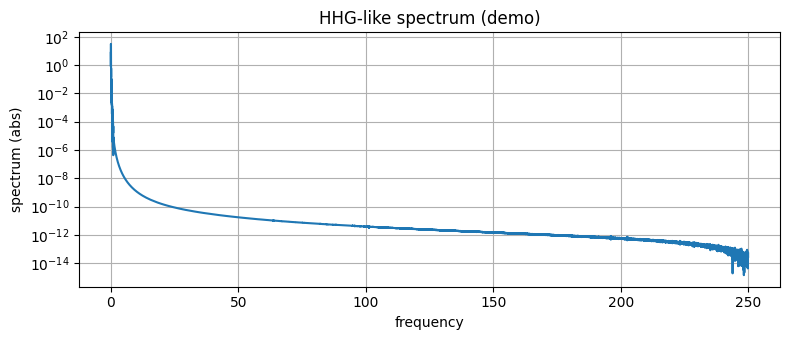

(array([0.        , 0.00200006, 0.00400011, 0.00600017, 0.00800022]),
 array([ 2.75841414e-17, -5.65325088e-13, -4.51772564e-12, -1.52476457e-11,
        -3.61417055e-11]),
 array([0.        , 0.0138885 , 0.02777701, 0.04166551, 0.05555401]),
 array([ 7.30483537,  0.81154781, 15.93583354, 31.32279981, 21.82285963]))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#Model Functions
sigma_x = np.array([[0,1],[1,0]], dtype=complex)
sigma_y = np.array([[0,-1j],[1j,0]], dtype=complex)
sigma_z = np.array([[1,0],[0,-1]], dtype=complex)
identity2 = np.eye(2, dtype=complex)

def H0_k(kx, ky, Delta):
    """2x2 Hamiltonian H0(kx,ky) as in problem (Eq.13)."""
    dx = np.sin(kx)
    dy = np.sin(ky)
    dz = Delta + np.cos(kx) + np.cos(ky)
    return dx * sigma_x + dy * sigma_y + dz * sigma_z

def dH0_dkx(kx, ky):
    """Derivative of H0 w.r.t. kx: cos(kx)*sigma_x - sin(kx)*sigma_z"""
    return np.cos(kx) * sigma_x - np.sin(kx) * sigma_z

def A_field(t, A0=0.5, Nc=10, omega0=None):
    if omega0 is None:
        omega0 = np.pi/(2*Nc)
    return A0 * np.sin(omega0 * t) * (np.sin(omega0 * t / (2 * Nc)))**2

#Utilities
def analytic_2x2_exp(H, dt):
    """
    Compute U = exp(-i H dt) for Hermitian 2x2 H using the closed form
    e^{-i(H)dt} = e^{-i h0 dt} [ cos(E dt) I - i sin(E dt)/E (H - h0 I) ]
    where h0 = (1/2) Tr(H), and E = sqrt(Tr((H-h0 I)^2)/2).
    """
    h0 = 0.5 * np.trace(H)
    Htr = H - h0 * identity2
    # compute E
    E2 = 0.5 * np.trace(Htr @ Htr)
    E = np.sqrt(np.real(E2))
    if E < 1e-12:
        # small E fallback (Taylor expansion)
        return np.exp(-1j * h0 * dt) * (identity2 - 1j * Htr * dt)
    cos_term = np.cos(E * dt)
    sin_term = np.sin(E * dt)
    Utr = cos_term * identity2 - 1j * (sin_term / E) * Htr
    return np.exp(-1j * h0 * dt) * Utr

#Precompute grid and Berry connections 
def precompute_grid(Nkx=41, Nky=41, Delta=1.0, dk_shift=1e-6):
    kx_vals = np.linspace(-np.pi, np.pi, Nkx, endpoint=False)
    ky_vals = np.linspace(-np.pi, np.pi, Nky, endpoint=False)
    dkx = kx_vals[1] - kx_vals[0]
    dky = ky_vals[1] - ky_vals[0]
    # storage
    U_grid = np.zeros((Nkx, Nky, 2, 2), dtype=complex)  # eigenvectors (columns)
    Eval_grid = np.zeros((Nkx, Nky, 2), dtype=float)
    Agrid = np.zeros((Nkx, Nky, 2, 2), dtype=complex)

    for ix, kx in enumerate(kx_vals):
        for iy, ky in enumerate(ky_vals):
            H = H0_k(kx, ky, Delta)
            # eigh returns eigenvals ascending -> ev[0] ~ -E (lower), ev[1] ~ +E (upper)
            ev, evecs = np.linalg.eigh(H)
            U_grid[ix, iy] = evecs  # columns are eigenvectors
            Eval_grid[ix, iy] = ev

    # compute A^x (Berry connection matrix) at each (kx,ky)
    # off-diagonal via A_pm = i <p| dH/dkx |m> / (Em - Ep)
    # diagonal via finite-difference derivative of eigenvectors
    for ix, kx in enumerate(kx_vals):
        for iy, ky in enumerate(ky_vals):
            U = U_grid[ix, iy]
            ev = Eval_grid[ix, iy]
            dH = dH0_dkx(kx, ky)
            # rotated matrix elements <p| dH |m>
            md = U.conj().T @ dH @ U
            A = np.zeros((2,2), dtype=complex)
            # off-diagonals
            for p in range(2):
                for m in range(2):
                    if p != m:
                        denom = ev[m] - ev[p]
                        if np.abs(denom) < 1e-12:
                            A[p,m] = 0.0
                        else:
                            A[p,m] = 1j * md[p,m] / denom
            # diagonals via finite difference of eigenvectors w.r.t kx
            # small shift
            dk = dk_shift
            H_plus = np.linalg.eigh(H0_k(kx+dk, ky, Delta))[1]
            H_minus = np.linalg.eigh(H0_k(kx-dk, ky, Delta))[1]
            # Align phases: make inner product with original vectors positive real
            # original U columns:
            u0 = U[:,0].copy()
            u1 = U[:,1].copy()
            # pick phased versions from shifted grids that maximize overlap
            up0 = H_plus[:,0]; um0 = H_minus[:,0]
            up1 = H_plus[:,1]; um1 = H_minus[:,1]
            # ensure consistent phases
            if np.vdot(u0, up0) < 0:
                up0 *= -1
            if np.vdot(u1, up1) < 0:
                up1 *= -1
            if np.vdot(u0, um0) < 0:
                um0 *= -1
            if np.vdot(u1, um1) < 0:
                um1 *= -1
            # finite-difference derivative du/dkx ≈ (u(k+dk)-u(k-dk))/(2dk)
            du0 = (up0 - um0) / (2*dk)
            du1 = (up1 - um1) / (2*dk)
            A[0,0] = 1j * np.vdot(u0, du0)
            A[1,1] = 1j * np.vdot(u1, du1)
            Agrid[ix, iy] = A

    return kx_vals, ky_vals, dkx, dky, U_grid, Eval_grid, Agrid

#Time evolution
def run_simulation(Delta=1.0, A0=0.5, Nc=6, Nkx=41, Nky=41, dt=0.002, Tfactor=1.0):
    # precompute
    omega0 = np.pi / (2 * Nc)
    kx_vals, ky_vals, dkx, dky, U_grid, Eval_grid, Agrid = precompute_grid(Nkx, Nky, Delta)
    # time grid for one pump period
    T = 2*np.pi * Nc / omega0
    # optionally scale T by Tfactor 
    T = T * Tfactor
    Nt = int(np.round(T / dt))
    time = np.linspace(0, T, Nt)
    j_t = np.zeros(Nt, dtype=float)

    # initial density matrix in eigenbasis (occupy lower band -> eigenval[0])
    rho0 = np.array([[1.0, 0.0],[0.0, 0.0]], dtype=complex)

    # loop
    for it in tqdm(range(Nt), desc="Time steps"):
        t = time[it]
        Ax = A_field(t, A0=A0, Nc=Nc, omega0=omega0)
        j_sum = 0.0
        for ix, kx in enumerate(kx_vals):
            for iy, ky in enumerate(ky_vals):
                U = U_grid[ix, iy]
                Aconn = Agrid[ix, iy]
                # shifted Hamiltonian evaluated at kx - Ax
                Hshift = H0_k(kx - Ax, ky, Delta)
                # rotate into eigenbasis at original k
                Htilde = U.conj().T @ Hshift @ U
                # rotated derivative evaluated at shifted point 
                dHshift = dH0_dkx(kx - Ax, ky)
                dHtilde = U.conj().T @ dHshift @ U
                # current operator in eigenbasis
                jtilde = dHtilde + 1j * (Htilde @ Aconn - Aconn @ Htilde)
                # get evolution operator for the small dt for Htilde
                U_evol = analytic_2x2_exp(Htilde, dt)
                try:
                    rho_grid
                except NameError:
                    rho_grid = np.tile(rho0, (Nkx, Nky, 1, 1)).astype(complex)
                rho_grid[ix, iy] = U_evol @ rho_grid[ix, iy] @ U_evol.conj().T
                j_loc = np.trace(jtilde @ rho_grid[ix, iy]).real
                j_sum += j_loc
        # average over BZ: multiply by area element and divide by (2pi)^2
        area_element = dkx * dky
        j_t[it] = (j_sum * area_element) / (2*np.pi)**2

    return time, j_t

# Run a small demo
time, j_t = run_simulation(Delta=1.0, A0=0.5, Nc=6, Nkx=41, Nky=41, dt=0.002, Tfactor=0.5)

# Plot current vs time
plt.figure(figsize=(8,3.5))
plt.plot(time, j_t)
plt.xlabel('t')
plt.ylabel(r'$\langle j_x(t)\rangle$')
plt.title('Driven Chern insulator: current (demo)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute and plot HHG spectrum (FFT)
j_zero_mean = j_t - np.mean(j_t)
Nt = len(j_zero_mean)
dt = time[1] - time[0]
Jf = np.fft.rfft(j_zero_mean * np.hanning(Nt))
freqs = np.fft.rfftfreq(Nt, dt)
spectrum = np.abs(Jf)

plt.figure(figsize=(8,3.5))
plt.semilogy(freqs, spectrum + 1e-16)  # small offset to avoid log(0)
plt.xlabel('frequency')
plt.ylabel('spectrum (abs)')
plt.title('HHG-like spectrum (demo)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Return final arrays as output of the cell 
time[:5], j_t[:5], freqs[:5], spectrum[:5]
